# cadCAD memory buster

Danilo Lessa Bernardineli

---

An cadCAD model for frying the thread memory. 

For every timestep, an constant number of random points are appended to an state variable array. This can be useful for diagonistics

In [1]:
%%capture
!pip install cadCAD

In [2]:
import numpy as np
import sys
import psutil
import os

## Model

### Logic

In [3]:
def s_add_things(params, timestep, history, prev_state, policy_input):
  things = prev_state['things']
  N = params['N']
  values = np.random.rand(N)
  things = np.append(things, values)
  return ('things', things)



def s_measure_history(params, timestep, history, prev_state, policy_input):
  used_bytes = sum([sys.getsizeof(l.get('things', 0)) for h in history for l in h])
  return ('history_bytes', used_bytes)


def s_measure_state(params, timestep, history, prev_state, policy_input):
  used_bytes = sys.getsizeof(prev_state['things'])
  return ('state_bytes', used_bytes)


def s_measure_process(params, timestep, history, prev_state, policy_input):
  process = psutil.Process(os.getpid())
  used_bytes = process.memory_info().data
  return ('process_bytes', used_bytes)



def s_erase_history(params, timestep, history, prev_state, policy_input):
  
  for a in history:
    for b in a:
      b['things'] = None
  return ('nothing', None)

### Structure

In [4]:
partial_state_update_blocks = [
  {
      'policies': {},
      'variables': {
          'things': s_add_things,
      }
  },
  {
      'policies': {},
      'variables': {
          'state_bytes': s_measure_state,
      }
  },
  {
      'policies': {},
      'variables': {
          'history_bytes': s_measure_history,
      }
  },
  {
      'policies': {},
      'variables': {
          'process_bytes':s_measure_process,
      }
  },
  {
      'policies': {},
      'variables': {
          'nothing': s_erase_history
      }
  },
]

In [5]:
genesis_state = {
    'things': np.array([0.0, 1.0]),
    'state_bytes': None,
    'history_bytes': None,
    'process_bytes': None,
    'nothing': None
}

T = int(1000)

params = {'N': int(1e4)}

**Actual cadCAD usage**

In [ ]:
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



sim_config = (
    {
        'N': 1,
        'T': range(T), # number of timesteps
        'M': params
    }
)


config = Configuration(
    sim_config=sim_config,
    initial_state=genesis_state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
raw_data = pd.DataFrame(raw_result[0][0])


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7f7fd5fd7a20>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f7fd5fd7a20>]


In [ ]:
data = (raw_data.drop(columns=['things', 'run', 'substep', 'nothing'])
                .set_index('timestep')
                .loc[1:]
                .div(1024 * 1024))

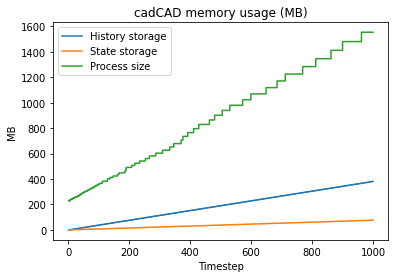

In [ ]:
plt.title("cadCAD memory usage (MB)")
plt.plot(data.history_bytes, label='History storage')
plt.plot(data.state_bytes, label='State storage')
plt.plot(data.process_bytes, label='Process size')
plt.ylabel("MB")
plt.xlabel("Timestep")
plt.legend()
plt.show()

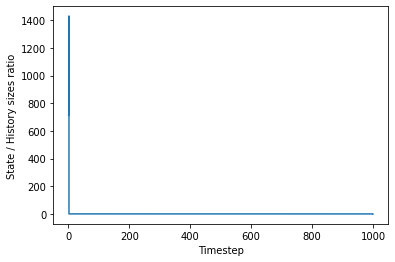

In [ ]:
y = (data.state_bytes / data.history_bytes)
plt.xlabel("Timestep")
plt.ylabel("State / History sizes ratio")
plt.plot(y)

In [ ]:
data.tail(2)

,state_bytes,history_bytes,process_bytes
timestep,,,
1000,76.294052,381.164948,1554.097656
1000,76.294052,381.164948,1554.097656
